This script will generate the average faces for each of the 24 identities that I showed in the famous face picture task.

# Setup

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import os
from glob import glob

import numpy as np
import pandas as pd

import skimage.io as io
io.use_plugin('matplotlib')

import moviepy.editor as mpy

import menpo
import menpo.io as mio
from menpo.io import export_image, export_landmark_file
from menpowidgets import visualize_images

from pathlib import Path

from tqdm import tqdm

In [3]:
import cv2
from menpo.shape import PointCloud
from menpo.shape import PointDirectedGraph
from menpo.shape import bounding_box

from menpodetect.dlib import load_dlib_frontal_face_detector
from menpodetect.pico import load_pico_frontal_face_detector
from menpodetect.ffld2 import load_ffld2_frontal_face_detector

dlib_detector = load_dlib_frontal_face_detector()
pico_detector = load_pico_frontal_face_detector()
ffld2_detector = load_ffld2_frontal_face_detector()

from menpofit.dlib import DlibWrapper as dlib_fitter
predictor_path = "/data1/famface01/data/misc/shape_predictor_68_face_landmarks.dat"
dlib = dlib_fitter(predictor_path)

from menpo.landmark import face_ibug_68_to_face_ibug_68_trimesh, face_ibug_68_to_face_ibug_68, labeller

face_parts = {
    'chin': range(17),              # 0:16
    'left-eyebrow': range(17,22),   # 17:21
    'right-eyebrow': range(22,27),  # 22:26
    'nose': range(27,36),           # 27:35
    'left-eye': range(36,42),       # 36:41
    'right-eye': range(42,48),      # 42:47
    'outer-mouth': range(48,60),    # 48:59
    'inner-mouth': range(60,68)     # 60:67
}
face_parts['eyebrow'] = face_parts['left-eyebrow'] + face_parts['right-eyebrow']
face_parts['eye'] = face_parts['left-eye'] + face_parts['right-eye']

blue = (255,0,0)
red  = (0,0,255)
green= (0,255,0)


def add_feature(im, land, part, isClosed, color, *args, **kwrds):
    pts = land[face_parts[part],]
    pts = pts.reshape((-1,1,2))
    cv2.polylines(im, [pts], isClosed, color, *args, **kwrds)

def add_landmarks(img, land, color=red, thick=1):
  add_feature(img, land, 'chin', False, color, thick)
  add_feature(img, land, 'left-eyebrow', False, color, thick)
  add_feature(img, land, 'right-eyebrow', False, color, thick)
  add_feature(img, land, 'nose', False, color, thick)
  add_feature(img, land, 'left-eye', True, color, thick)
  add_feature(img, land, 'right-eye', True, color, thick)
  add_feature(img, land, 'outer-mouth', True, color, thick)
  add_feature(img, land, 'inner-mouth', True, color, thick)
  return img


def image_to_menpo(image):
    menpo_image = menpo.image.Image(np.rollaxis(image, 2, 0))
    return menpo_image

def image_to_menpo_float32(image):
    image = np.rollaxis(image, 2, 0)
    image = menpo.image.base.normalize_pixels_range(image).astype(np.float32)
    menpo_image = menpo.image.Image(image)
    return menpo_image

def menpo_to_image(menpo_image):
    image = np.rollaxis(menpo_image.pixels, 0, 3)
    #np.stack((menpo_image.pixels[0,:,:], menpo_image.pixels[1,:,:], menpo_image.pixels[2,:,:]), axis=-1)
    return image

def add_landmarks_menpo(orig_img, menpo_img, out_menpo=True, *args, **kwrds):
    limg = np.copy(orig_img)

    lands = menpo_img.landmarks['PTS'].lms
    lands = np.fliplr(lands.h_points().T[:,:2])

    limg = add_landmarks(limg, lands, *args, **kwrds)
    if out_menpo: limg = image_to_menpo(limg)
    
    return limg

def add_bounding_box(img, bbox):
    bbox0 = bounding_box(bbox.h_points().T[:,:2][0,:], bbox.h_points().T[:,:2][2,:])
    img.landmarks['bbox_0'] = bbox0
    return bbox0

def find_bounding_box(img, verbose=False):
    pcs = dlib_detector(img, group_prefix='bbox')
    detector = 'dlib'
    if len(pcs) == 0:
        pcs = pico_detector(img, group_prefix='bbox')
        detector = 'pico'
        if len(pcs) == 0:
            pcs = ffld2_detector(img, group_prefix='bbox')
            detector = 'ffld2'
            if len(pcs) == 0:
                if verbose: print('no bbox found')
                detector = None
                pcs = None
    return (pcs, detector)

def find_landmarks(img):
    if 'bbox_0' not in img.landmarks:
        pcs,detector = find_bounding_box(img)
    fit = dlib.fit_from_bb(img, img.landmarks['bbox_0'].lms)
    img.landmarks['PTS'] = fit.final_shape
    return fit

def crop_face(img):
    pc = img.landmarks['PTS'].lms
    imins, imaxs = pc.bounds()
    img2  = img.crop([imins[0]-((imaxs[0]-imins[0])*0.5), imins[1]-((imaxs[1]-imins[1])*0.1)], 
                     [imaxs[0]+((imaxs[0]-imins[0])*0.05), imaxs[1]+((imaxs[1]-imins[1])*0.1)], 
                     True)
    return img2

def zload_vid(ifname):
    small_size = [640,360]
    large_size = [854,480]

    vid = mpy.VideoFileClip(ifname)
    
    # Fix vid size if needed
    if (vid.size[0]<640) | (vid.size[1]<360):
        vid = vid.on_color(size=small_size, color=(0,0,0))
    elif ((vid.size[0]>640) & (vid.size[0]<854)) | ((vid.size[1]>360) & (vid.size[1]<480)):
        vid = vid.on_color(size=large_size, color=(0,0,0))
    elif (vid.size[0]==640) & (vid.size[1]==480):
        vid = vid.on_color(size=large_size, color=(0,0,0))
    
    return vid

# Load

## Paths, etc

First, we get the identities from the task.
Second, we search in another directory with a larger set of pictures to use to make the average.

In [ ]:
# First we get the identities from the task
fpaths = sorted(glob("/data1/famface01/data/stimuli/pics/fampics_task/*/*"))
lst_ids = [ os.path.basename(os.path.dirname(fpath)) for fpath in fpaths ]
uids = np.unique(lst_ids)

In [ ]:
# Second we search in another directory with a larger set of pictures to use to make the average
base = '/data1/famface01/data/stimuli/pics/famous_64/compiled'
d_fpaths = { uid : sorted(glob('%s/%s/*.jpg' % (base, uid))) for uid in uids }
d_fpaths[uids[1]][:10]

In [ ]:
uids

## Data, landmark, etc

Save the landmarks for all the photos for later use.

In [ ]:
for uid in uids:
    print(uid)
    fpaths = d_fpaths[uid]
    for fpath in tqdm(fpaths):
        pts_file = "%s/%s" % (os.path.dirname(fpath), os.path.basename(fpath).replace(".jpg", ".pts"))
                
        # Get the landmarks if needed
        if not os.path.exists(pts_file):
            try:
                # Read
                img = mio.import_image(fpath)
            except ValueError, e:
                print(e)
                continue

            # Bounding Box
            pcs, detector = find_bounding_box(img)

            # Landmarks
            find_landmarks(img)
            
            # Save
            export_landmark_file(img.landmarks['PTS'], pts_file, overwrite=True)

In [ ]:
visualize_images(d_images['Angelina_Jolie'])

Save the landmarks for future use.

# Average

In [ ]:
from menpo.shape import mean_pointcloud, PointCloud
from menpofit.builder import (compute_reference_shape, rescale_images_to_reference_shape, 
                              warp_images, build_reference_frame, align_shapes)
from menpofit.transform import DifferentiablePiecewiseAffine

def load_images(fpaths):
    images = []
    for fpath in tqdm(fpaths):
        # Read
        try:
            img = mio.import_image(fpath)
            img = img.crop_to_landmarks_proportion(0.1)

            # Add other landmarker things
            labeller(img, 'PTS', face_ibug_68_to_face_ibug_68_trimesh)
            labeller(img, 'face_ibug_68_trimesh', face_ibug_68_to_face_ibug_68)

            # Save
            images.append(img)
        except ValueError, e:
            print(e)
    return images

def wrap_warp_images(images, diagonal=200, group='face_ibug_68_trimesh', scale_prefix='  - ', verbose=True):
    # Get reference
    ref_shape   = compute_reference_shape([i.landmarks[group].lms for i in images], diagonal, verbose=verbose)
    shape_batch = [i.landmarks[group].lms for i in images]
    mean_aligned_shape = mean_pointcloud(align_shapes(shape_batch))
    reference_frame    = build_reference_frame(mean_aligned_shape)
    
    # Scale size
    image_batch = rescale_images_to_reference_shape(images, group, mean_aligned_shape, verbose=verbose)
    shape_batch = [i.landmarks[group].lms for i in image_batch]
    
    # Warp to reference
    warped_images = warp_images(image_batch, shape_batch, reference_frame, DifferentiablePiecewiseAffine,
                               prefix=scale_prefix, verbose=True)
    
    return warped_images

def ave_warped_imgs(warped_images, group='face_ibug_68_trimesh'):
    imgs = np.array([ img.pixels for img in warped_images ])
    shapes = [ img.landmarks['source'].lms for img in warped_images ]
    
    ave_img0 = np.mean(imgs, axis=0)
    ave_shape0 = mean_pointcloud(shapes)

    ave_img = menpo.image.Image(ave_img0)
    ave_img.landmarks[group] = ave_shape0
    
    return ave_img

In [ ]:
average_images = []
for uid in uids:
    print()
    print(uid)
    images = load_images(d_fpaths[uid])
    warped_images = wrap_warp_images(images)
    ave_img = ave_warped_imgs(warped_images)
    average_images.append(ave_img)

In [ ]:
visualize_images(average_images)

# Save

## Average Face

In [5]:
odir = "/data1/famface01/data/stimuli/pics/fampics_average"
if not os.path.exists(odir): os.mkdir(odir)

In [ ]:
average_images[0]
for i,aimg in tqdm(enumerate(average_images), total=len(average_images)):
    uid       = uids[i]
    img_path  = '%s/%s.jpg' % (odir, uid)
    land_path = '%s/%s.pts' % (odir, uid)
    
    export_image(aimg, img_path, overwrite=True)
    export_landmark_file(aimg.landmarks['face_ibug_68_trimesh'], land_path, overwrite=True)

In [6]:
fpaths = sorted(glob("%s/*.jpg" % odir))
average_images = []
for fpath in fpaths:
    img = mio.import_image(fpath)
    average_images.append(img)

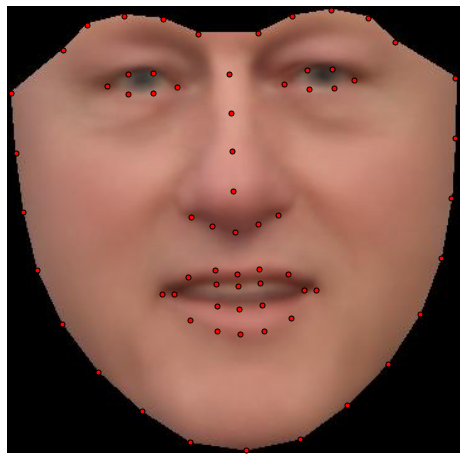

In [7]:
visualize_images(average_images)

## Masked Faces

I also want to save all the faces that went into the landmark in terms of their masked faces and landmarks.

In [ ]:
odir = "/data1/famface01/data/stimuli/pics/fampics_masked"
if not os.path.exists(odir): os.mkdir(odir)

In [ ]:
for uid in uids:
    print(uid)
    fpaths = d_fpaths[uid]
    for fpath in tqdm(fpaths):
        # Paths
        udir = "%s/%s" % (odir, uid)
        if not os.path.exists(udir): os.mkdir(udir)
        img_file = "%s/%s" % (udir, os.path.basename(fpath))
        pts_file = "%s/%s" % (udir, os.path.basename(fpath).replace(".jpg", ".pts"))

        if (not os.path.exists(img_file)) and (not os.path.exists(pts_file)):
            try:
                img  = mio.import_image(fpath)
                img  = img.crop_to_landmarks_proportion(0.1)
                if img.diagonal() > 800:
                    img = img.rescale_to_diagonal(800)
                mimg = img.as_masked().constrain_mask_to_landmarks(group='PTS')

                export_image(mimg, img_file, overwrite=True)
                export_landmark_file(mimg.landmarks['PTS'], pts_file, overwrite=True)

                del img, mimg
            except ValueError, e:
                print(e)

In [ ]:
# Fix for old...this will overwrite larger images for the first few faces
for uid in uids[:6]:
    print(uid)
    fpaths = d_fpaths[uid]
    for fpath in tqdm(fpaths):
        # Paths
        udir = "%s/%s" % (odir, uid)
        if not os.path.exists(udir): os.mkdir(udir)
        img_file = "%s/%s" % (udir, os.path.basename(fpath))
        pts_file = "%s/%s" % (udir, os.path.basename(fpath).replace(".jpg", ".pts"))
        
        img  = mio.import_image(fpath)
        img  = img.crop_to_landmarks_proportion(0.1)
        if img.diagonal() > 800:
            #print('large overwrite')
            img = img.rescale_to_diagonal(800)
            mimg = img.as_masked().constrain_mask_to_landmarks(group='PTS')
            export_image(mimg, img_file, overwrite=True)
            export_landmark_file(mimg.landmarks['PTS'], pts_file, overwrite=True)
            del  mimg
        del img
    